In [3]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
#用于序列到序列学习的循环神经网络编码器
class Seq2SeqEncoder(d2l.Encoder):

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 将词索引映射成嵌入向量
        X = self.embedding(X)
        # 调整输出向量的维度
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        return output, state

In [5]:
# permute的用法 用于调整向量的维度
import torch

# 假设有一个形状为 (2, 3, 4) 的张量
temp = torch.randn(2, 3, 4)
print("原始张量的形状:", temp.shape)

# 使用 permute 重新排列维度
temp_permuted = temp.permute(1, 0, 2)
# 重新排列维度后的形状: torch.Size([3, 2, 4])
print("重新排列维度后的形状:", temp_permuted.shape)

# 打印原始张量和重新排列后的张量
print("原始张量:\n", temp)
print("重新排列后的张量:\n", temp_permuted)

原始张量的形状: torch.Size([2, 3, 4])
重新排列维度后的形状: torch.Size([3, 2, 4])
原始张量:
 tensor([[[-0.2167, -0.7214, -1.1619,  0.7126],
         [ 0.7325, -0.1458, -0.5945, -1.1517],
         [ 0.4763,  1.1110,  0.4661,  1.6304]],

        [[ 0.4059, -1.0617,  0.1535, -1.8772],
         [ 0.4663,  0.7954,  0.9865, -0.4461],
         [-0.0192, -0.1635, -0.1410,  1.0554]]])
重新排列后的张量:
 tensor([[[-0.2167, -0.7214, -1.1619,  0.7126],
         [ 0.4059, -1.0617,  0.1535, -1.8772]],

        [[ 0.7325, -0.1458, -0.5945, -1.1517],
         [ 0.4663,  0.7954,  0.9865, -0.4461]],

        [[ 0.4763,  1.1110,  0.4661,  1.6304],
         [-0.0192, -0.1635, -0.1410,  1.0554]]])


In [6]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
# eval()用于将模型设置为评估模式
encoder.eval()
# batch_size = 4, num_steps = 7
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
# output的形状:(num_steps,batch_size,num_hiddens)
output.shape

torch.Size([7, 4, 16])

In [7]:
# state的形状:(num_layers,batch_size,num_hiddens)
state.shape

torch.Size([2, 4, 16])

# 编码器的前向传播计算

---

## 初始输入

```python
X = torch.zeros((4, 7), dtype=torch.long)
```

- **形状**: `(batch_size, num_steps)` = `(4, 7)`
  - `batch_size=4`: 输入批次中的样本数为 4。
  - `num_steps=7`: 每个序列的时间步数（词的个数）为 7。

---

## 1. 嵌入层 (`self.embedding`)

嵌入层的作用是将每个词索引映射为对应的嵌入向量。嵌入层的权重矩阵（通常称为嵌入矩阵）大小为 `(vocab_size, embed_size)`，其中：
- `vocab_size=10`: 词汇表的大小，表示可用的词索引范围是 `[0, 9]`。
- `embed_size=8`: 每个词将被表示为 8 维的向量。

嵌入层的计算过程如下：
1. **输入数据**:
   - 输入张量 `X` 的形状是 `(batch_size, num_steps)` = `(4, 7)`。
   - 张量中的每个值是一个整数，表示词汇表中的索引。例如：
     ```python
     X = [[0, 1, 2, 3, 4, 5, 6],
          [7, 8, 9, 0, 1, 2, 3],
          [4, 5, 6, 7, 8, 9, 0],
          [1, 2, 3, 4, 5, 6, 7]]
     ```

2. **嵌入矩阵查找**:
   - 对于每个词索引（例如 `0`, `1`, `2` 等），嵌入层会从嵌入矩阵中查找对应的嵌入向量。
   - 嵌入矩阵的形状为 `(vocab_size, embed_size)` = `(10, 8)`：
     ```python
     embedding_matrix = [
         [0.2, 0.1, -0.3, ..., 0.8],  # 嵌入向量 for 索引 0
         [0.5, -0.6, 0.7, ..., -0.1], # 嵌入向量 for 索引 1
         ...
         [-0.3, 0.4, 0.1, ..., 0.6],  # 嵌入向量 for 索引 9
     ]
     ```
   - 每个索引值会被映射到嵌入矩阵中的一行。例如：
     - 索引 `0` → `[0.2, 0.1, -0.3, ..., 0.8]` (8 维向量)
     - 索引 `1` → `[0.5, -0.6, 0.7, ..., -0.1]` (8 维向量)

3. **输出张量**:
   - 嵌入层为每个时间步的词索引生成一个嵌入向量。
   - 输入形状 `(batch_size, num_steps)` = `(4, 7)` 转换为：
     **`(batch_size, num_steps, embed_size)`** = `(4, 7, 8)`。
---
## 2. 维度调整 (`permute`)

**计算原理**:
为了适配循环神经网络（RNN）的输入格式，需要将时间步数（`num_steps`）调整到张量的第一维。
PyTorch 的 RNN 模块要求输入的形状为 `(num_steps, batch_size, embed_size)`。

```python
X = X.permute(1, 0, 2)
```

- **输入形状**: `(batch_size, num_steps, embed_size)` = `(4, 7, 8)`
- **输出形状**: `(num_steps, batch_size, embed_size)` = `(7, 4, 8)`
  - `num_steps=7`: 序列的长度（时间步数）。
  - `batch_size=4`: 批量大小。
  - `embed_size=8`: 嵌入向量的维度。

---

## 3. GRU 编码器 (`self.rnn`)

**计算原理**:
GRU 是一种循环神经网络（RNN），接受一个形状为 `(num_steps, batch_size, embed_size)` 的输入张量，计算每个时间步的隐藏状态，并输出：
1. 每个时间步的隐藏状态序列（`output`）。
2. 最终的隐藏状态（`state`）。

GRU 的输入向量维度为 `embed_size=8`，隐藏层状态的维度为 `num_hiddens=16`，网络有 `num_layers=2` 层。

```python
output, state = self.rnn(X)
```

- **输入形状**: `(num_steps, batch_size, embed_size)` = `(7, 4, 8)`
- **输出结果**:
  1. **`output`**: 每个时间步的隐藏状态序列。
     - **形状**: `(num_steps, batch_size, num_hiddens)` = `(7, 4, 16)`
       - `num_steps=7`: 序列的长度（时间步数）。
       - `batch_size=4`: 批量大小。
       - `num_hiddens=16`: GRU 的隐藏状态维度。
  2. **`state`**: 最终的隐藏状态。
     - **形状**: `(num_layers, batch_size, num_hiddens)` = `(2, 4, 16)`
       - `num_layers=2`: GRU 的层数。
       - `batch_size=4`: 批量大小。
       - `num_hiddens=16`: GRU 的隐藏状态维度。



In [8]:
# 解码器
class Seq2SeqDecoder(d2l.Decoder):

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    # 解码器的输入就是编码器的输出
    # X是一开始输入的变量(4,7) state(2,4,16)
    def forward(self, X, state):
        # 嵌入层 X(4,7)->(7,4,8)
        X = self.embedding(X).permute(1, 0, 2)
        # 从隐状态中提取信息，并将其与嵌入向量进行
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [9]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
# encoder(X) 返回两个内容 一个是上下文变量c 一个是隐状态state
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
# output的形状为
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

# 解码器的前向传播计算
## 1. 编码器输出

假设编码器的输出为：
- **`enc_outputs`**:
  - `enc_outputs[0]` (编码器的输出序列): `(num_steps_enc, batch_size, num_hiddens)` = `(7, 4, 16)`
  - `enc_outputs[1]` (编码器的隐藏状态): `(num_layers, batch_size, num_hiddens)` = `(2, 4, 16)`

在解码器中，编码器的隐藏状态 `enc_outputs[1]` 被用作解码器的初始状态。

---

## 2. 解码器输入

解码器的输入由两部分组成：
1. 目标序列的词索引 `X`：
   - 假设目标序列的形状为 `(batch_size, num_steps_dec)` = `(4, 7)`。
   - 其中，`batch_size=4` 表示批量大小，`num_steps_dec=7` 表示目标序列的时间步数。

2. 编码器的隐藏状态 `state`：
   - 由 `enc_outputs[1]` 初始化，形状为 `(num_layers, batch_size, num_hiddens)` = `(2, 4, 16)`。

---

## 3. 嵌入层 (`self.embedding`)

**计算原理**:
嵌入层将目标序列的词索引映射为对应的嵌入向量。嵌入层的权重矩阵大小为 `(vocab_size, embed_size)`，其中：
- `vocab_size=10`: 目标词汇表大小。
- `embed_size=8`: 每个词被映射为 8 维的嵌入向量。

**计算过程**:
1. 输入 `X` 的形状为 `(batch_size, num_steps_dec)` = `(4, 7)`。
2. 嵌入层将其映射为 `(batch_size, num_steps_dec, embed_size)` = `(4, 7, 8)`。
3. 调整维度顺序 `.permute(1, 0, 2)`，输出形状为 `(num_steps_dec, batch_size, embed_size)` = `(7, 4, 8)`。

---

## 4. 广播上下文

**计算原理**:
解码器需要从编码器传递的隐藏状态中提取上下文信息，并将其与目标序列的嵌入向量结合。

**计算过程**:
1. state[-1]: 获取编码器最后一层隐藏状态，形状为 (batch_size, num_hiddens)。
state 的形状是 (2, 4, 16)，那么 state[-1] 的形状为 (4, 16)。

2. .repeat(X.shape[0], 1, 1):
X.shape[0] 是解码器的时间步数（num_steps），这里为 7。
.repeat 的作用是扩展 state[-1] 的形状：
在第 0 维（时间步数）上重复 7 次。
在第 1 维（批量大小）和第 2 维（隐藏状态维度）上保持不变。

3. 输出 context:
广播后的 context 的形状为 (num_steps, batch_size, num_hiddens)。
假设 state[-1] 的形状是 (4, 16)，广播后 context 的形状为 (7, 4, 16)
---

## 5. 拼接输入与上下文

**计算原理**:
将目标序列的嵌入向量与广播后的上下文在最后一个维度上拼接，以便 GRU 同时处理目标序列输入和上下文信息。

**计算过程**:
1. 嵌入层输出 `X` 的形状为 `(num_steps_dec, batch_size, embed_size)` = `(7, 4, 8)`。
2. 广播后的上下文 `context` 的形状为 `(num_steps_dec, batch_size, num_hiddens)` = `(7, 4, 16)`。
3. 拼接后，`X_and_context` 的形状为 `(num_steps_dec, batch_size, embed_size + num_hiddens)` = `(7, 4, 24)`。

---

## 6. GRU 层 (`self.rnn`)

**计算原理**:
GRU 接收拼接后的输入 `X_and_context` 和初始隐藏状态 `state`，逐步计算每个时间步的隐藏状态和最终输出。

**计算过程**:
1. 输入 `X_and_context` 的形状为 `(num_steps_dec, batch_size, embed_size + num_hiddens)` = `(7, 4, 24)`。
2. 初始隐藏状态 `state` 的形状为 `(num_layers, batch_size, num_hiddens)` = `(2, 4, 16)`。
3. GRU 的输出：
   - 每个时间步的隐藏状态序列 `output` 的形状为 `(num_steps_dec, batch_size, num_hiddens)` = `(7, 4, 16)`。
   - 最终隐藏状态 `state` 的形状为 `(num_layers, batch_size, num_hiddens)` = `(2, 4, 16)`。

---

## 7. 全连接层 (`self.dense`)

**计算原理**:
全连接层将 GRU 输出的隐藏状态映射到词汇表维度，用于预测目标序列中的词分布。

**计算过程**:
1. 全连接层的输入： 输入 output 的形状为 (num_steps_dec, batch_size, num_hiddens) = (7, 4, 16)。
2. 全连接层的权重和偏置： 权重矩阵的形状为 (num_hiddens, vocab_size) = (16, 10)。 偏置向量的形状为 (vocab_size,) = (10,)。
3. 全连接层的输出：映射后的形状为 (num_steps_dec, batch_size, vocab_size) = (7, 4, 10)。
4. 调整维度顺序 .permute(1, 0, 2)：将形状从 (num_steps_dec, batch_size, vocab_size) = (7, 4, 10) 调整为 (batch_size, num_steps_dec, vocab_size) = (4, 7, 10)。



### 从编码器输入到解码器输出的过程
#### **编码器部分**

1. **输入数据准备**
   源序列的词索引被提供给编码器。词索引是每个单词的唯一标识，用于表示输入序列。

2. **嵌入层处理**
   编码器通过嵌入层将词索引转换为嵌入向量。这些嵌入向量是稠密的表示形式，捕获了每个单词的语义信息。

3. **GRU 层处理**
   嵌入向量被输入到 GRU 层，编码器通过多层 GRU 提取序列的时间依赖关系和全局语义信息。
   GRU 的输出包括：
   - 每个时间步的隐藏状态序列。
   - 最终的隐藏状态。

4. **返回编码器结果**
   编码器的输出（上下文变量和隐藏状态）被传递给解码器，用于引导解码过程。

---

#### **解码器部分**

1. **初始化解码器状态**
   解码器从编码器接收最终隐藏状态，作为解码器的初始状态，同时准备目标序列的词索引作为输入。

2. **目标序列嵌入**
   解码器通过嵌入层将目标序列的词索引转换为嵌入向量，这些向量表示目标序列的语义信息。

3. **广播上下文**
   编码器的上下文信息（最后一层隐藏状态）被广播到目标序列的每个时间步，确保解码器的每个时间步都能访问全局上下文信息。

4. **拼接输入与上下文**
   解码器将目标序列的嵌入向量与广播的上下文信息拼接在一起，作为解码器的输入。

5. **GRU 层处理**
   拼接后的输入被送入解码器的 GRU 层，逐步生成目标序列的隐藏状态序列，并更新内部隐藏状态。

6. **全连接层映射**
   解码器通过全连接层将 GRU 的隐藏状态映射到目标词汇表分布，用于预测目标序列中的每个词。

7. **输出调整**
   解码器调整输出的形状，使其符合目标序列的格式，生成最终的词分布，用于目标序列的预测。

---

#### **最终结果**

1. **输出分布**
   包含目标序列每个时间步的词分布，用于生成具体的目标词。

2. **最终隐藏状态**
   包含解码器的最终隐藏状态，可用于进一步的解码或其他操作。


In [13]:
# 损失函数部分
# 在数据集处理的过程中 通过在序列末尾填充特定的词元保持序列长度的相同
# 使用该函数通过零值化屏蔽不相关的项
def sequence_mask(X, valid_len, value=0):
    # 获取x的列数
    maxlen = X.size(1)
    # mask是一个二维数组
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X
# X 是一个二维张量，表示序列数据
# valid_len 是一个一维张量，表示每个序列需要保留的有效长度。
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))
# maxlen = 3
# mask = tensor([[ True, False, False],
#        [ True,  True, False]])

tensor([[1, 0, 0],
        [4, 5, 0]])


    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]

1. **`[None, :]`**
   - 给张量新增一个维度，形状从 `(maxlen,)` 变为 `(1, maxlen)`。
   - 示例:
     ```
     tensor([[0., 1., 2.]])
     ```
2. **`valid_len[:, None]`**
   - 将 `valid_len` 转换为二维张量，形状从 `(batch_size,)` 变为 `(batch_size, 1)`。
   - 示例（当 `valid_len = [1, 2]`）:
     ```
     tensor([[1.],
             [2.]])
     ```

3. **布尔掩码生成**
   - 利用 `<` 操作生成布尔掩码，表示哪些位置是有效的。
   - PyTorch 广播机制会将 `(1, maxlen)` 和 `(batch_size, 1)` 扩展为 `(batch_size, maxlen)`。
   - 示例：
     ```
     mask = [[True, False, False],
             [True, True, False]]
     ```

In [14]:
# 按照个人需求 可以使用指定非零值替代这些项
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [15]:
# 对交叉熵损失函数进行拓展
# 继承自 PyTorch 的 nn.CrossEntropyLoss
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # 模型预测输出pred的形状：(batch_size,num_steps,vocab_size)
    # 目标标签label的形状：(batch_size,num_steps)
    # 序列有效长度valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        # 创建一个与 label 形状相同的张量，所有元素初始化为 1
        weights = torch.ones_like(label)
        # 进行遮蔽
        weights = sequence_mask(weights, valid_len)
        # 不对批量数据的损失进行任何聚合（如求和或取平均），而是保留每个样本的逐元素损失。
        self.reduction='none'
        # 未加权损失
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        # 加权损失(遮蔽后的权重相乘)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [17]:
# 代码及安全性检查
# 输出结果应为 第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## Teacher Forcing

**Teacher Forcing** 是一种在序列到序列（Sequence-to-Sequence）模型（如机器翻译、文本生成等）训练过程中常用的技术。其核心思想是：

> 在解码器的训练过程中，使用目标序列的真实值（即目标词）作为解码器每一步的输入，而不是依赖模型自身在前一步生成的预测值。

---

### 工作原理

1. **编码器阶段**：
   - 编码器接收输入序列（如源语言句子），生成上下文向量（Context Vector）或隐藏状态。

2. **解码器阶段（使用 Teacher Forcing）**：
   - 在解码器的每个时间步：
     - **输入**：目标序列的真实值（即 Ground Truth）。
     - **输出**：预测的概率分布，用于计算损失。

3. **损失计算**：
   - 使用解码器的预测值与目标序列的真实值计算损失（如交叉熵损失），并进行反向传播优化模型。

---

### 优势

1. **加速模型训练**：
   - 使用目标序列的真实值作为输入，避免了模型错误的累积，从而使训练过程更加稳定。

2. **提高收敛效率**：
   - 模型可以更快地学习到目标序列的对齐关系和特征。

---

### 局限性

1. **测试阶段的输入差异**：
   - 在测试阶段，解码器只能依赖前一步生成的值作为下一步的输入，而不是目标序列的真实值。这种训练与测试阶段输入方式的不一致可能会导致模型性能下降。

2. **模型过于依赖真实值**：
   - 如果模型过于依赖真实值，可能会导致在测试阶段对错误的输入更敏感，从而影响生成质量。

In [26]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from d2l import torch as d2l

# 修改了代码中的绘图方法
# tgt_vocab: 目标词汇表，包含特殊标记（如 <bos>）。
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        # 对 nn.Linear 层的权重使用 Xavier 均匀分布初始化。
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            # 对GRU使用 Xavier 初始化
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()

    # 初始化 matplotlib 绘图
    epochs = list(range(1, num_epochs + 1))
    losses = []

    # 开始训练
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)

        # 记录每轮的平均损失
        avg_loss = metric[0] / metric[1]
        losses.append(avg_loss)

    # 绘制损失曲线
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, losses, label='Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f'Final loss {losses[-1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

## Xavier 初始化？

**Xavier 初始化** 是一种权重初始化方法，用于帮助神经网络的训练更快地收敛，并避免梯度消失或梯度爆炸问题。
---
### 核心思想

Xavier 初始化的目标是让**每一层的输入和输出的方差相同**，从而保持信号的稳定传播。
权重被初始化为一个均匀分布或正态分布，其标准差由神经元的输入和输出节点数量决定。

#### 公式

1. **均匀分布**：
   $$
   W \sim U\left(-\sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}, \sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}\right)
   $$

2. **正态分布**：
   $$
   W \sim N\left(0, \frac{2}{n_{\text{in}} + n_{\text{out}}}\right)
   $$

- \( n_{\text{in}} \): 当前层的输入神经元个数。
- \( n_{\text{out}} \): 当前层的输出神经元个数。

---

### 为什么需要 Xavier 初始化？

在深度学习中，**权重初始化不当**可能会导致以下问题：
1. **梯度消失**：如果权重太小，经过多层传播后，信号会逐渐衰减，导致梯度变得非常小，训练几乎停滞。
2. **梯度爆炸**：如果权重太大，信号会在层与层之间逐渐放大，导致梯度过大，训练不稳定甚至发散。

Xavier 初始化通过平衡输入和输出的方差，减少了这些问题的发生。


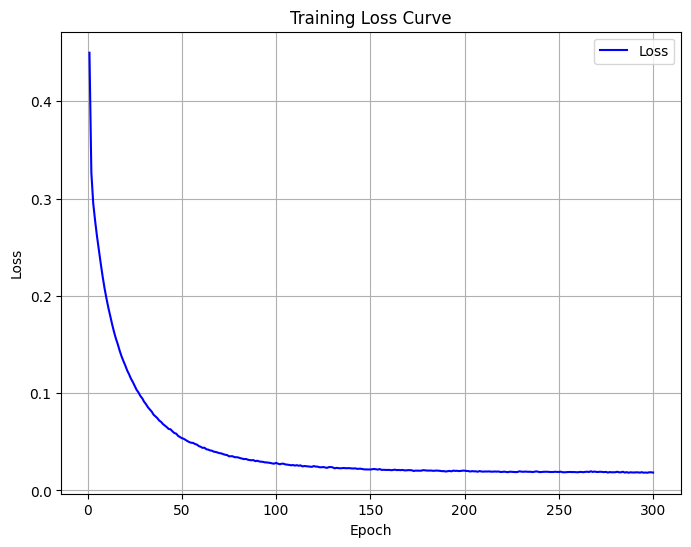

Final loss 0.018, 44500.1 tokens/sec on cuda:0


In [27]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [22]:
# 预测
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## 预测序列的评估

我们可以通过与真实的标签序列进行比较来评估预测序列。
虽然 :cite:`Papineni.Roukos.Ward.ea.2002`
提出的BLEU（bilingual evaluation understudy）
最先是用于评估机器翻译的结果，
但现在它已经被广泛用于测量许多应用的输出序列的质量。
原则上说，对于预测序列中的任意$n$元语法（n-grams），
BLEU的评估都是这个$n$元语法是否出现在标签序列中。

我们将BLEU定义为：

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

其中$\mathrm{len}_{\text{label}}$表示标签序列中的词元数和
$\mathrm{len}_{\text{pred}}$表示预测序列中的词元数，
$k$是用于匹配的最长的$n$元语法。
另外，用$p_n$表示$n$元语法的精确度，它是两个数量的比值：
第一个是预测序列与标签序列中匹配的$n$元语法的数量，
第二个是预测序列中$n$元语法的数量的比率。
具体地说，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$、$B$、$C$、$D$，
我们有$p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$和$p_4 = 0$。

根据 :eqref:`eq_bleu`中BLEU的定义，
当预测序列与标签序列完全相同时，BLEU为$1$。
此外，由于$n$元语法越长则匹配难度越大，
所以BLEU为更长的$n$元语法的精确度分配更大的权重。
具体来说，当$p_n$固定时，$p_n^{1/2^n}$
会随着$n$的增长而增加（原始论文使用$p_n^{1/n}$）。
而且，由于预测的序列越短获得的$p_n$值越高，
所以 :eqref:`eq_bleu`中乘法项之前的系数用于惩罚较短的预测序列。
例如，当$k=2$时，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$，尽管$p_1 = p_2 = 1$，
惩罚因子$\exp(1-6/2) \approx 0.14$会降低BLEU。

[**BLEU的代码实现**]如下。


In [23]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最后，利用训练好的循环神经网络“编码器－解码器”模型，
[**将几个英语句子翻译成法语**]，并计算BLEU的最终结果。


In [24]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va <unk> ., bleu 0.000
i lost . => j'ai <unk> <unk> ?, bleu 0.000
he's calm . => il est doucement ., bleu 0.658
i'm home . => je suis calme ., bleu 0.512
